# import

In [526]:
import sys
import os
import math
import numpy as np
import pandas as pd 
import xarray as xr
from scipy.stats import zscore
import matplotlib.pyplot as plt
import configparser



sys.path.insert(0, ".")
from post_minian.dataanalysis import (
    SessionData
)
from minian.utilities import (
    open_minian,
    match_information,
    match_path
)


# Settings

## Behavior settings

In [527]:
# Type of behavior and timewindow
event_dict = {'ALP':[-6,6],'IALP':[-6,6], 'RNFS':[-6,6], 'ALP_Timeout':[-6,6]}

In [528]:
event_list = [key for key in event_dict]
readout_list = ["AUC", "Frq", "Amp"]

In [529]:
# Data settings
# You need to set behavior data as the session data.
dpath = "/N/project/Cortical_Calcium_Image/Miniscope data/03.2023_Eighth_group/AA051_D8/2023_03_13/13_42_12/Miniscope_2/S4"
mouseID, day, session = match_information(dpath)
# mouseID = "AA017"
# day = 'D7'
# session = '1Hour'
mouse_path, video_path = match_path(dpath)
timeStamp = os.path.join(video_path,"timeStamps.csv")
minian_ds_path = os.path.join(dpath, "minian")
output_dpath = "/N/project/Cortical_Calcium_Image/data_analysis_Project1_30sec_Oct23th"
output_path = os.path.join(output_dpath, mouseID,day,session)
behavior_data=pd.read_csv(os.path.join(mouse_path, mouseID+"_"+day+"_"+session+"_behavior_ms.csv"),sep=',')


if(os.path.exists(output_path) == False):
    os.makedirs(output_path)

# Load data

In [530]:
data = open_minian(minian_ds_path)

In [531]:
neuron_ids = data['C'].coords['unit_id'].values

In [532]:
data

<xarray.Dataset>
Dimensions:      (frame: 27000, height: 608, shift_dim: 2, unit_id: 59, width: 608)
Coordinates:
    animal       <U11 'Miniscope_2'
  * height       (height) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
    session      <U2 'S4'
  * unit_id      (unit_id) int64 0 1 3 5 6 7 9 10 11 ... 78 79 80 81 82 83 84 85
    unit_labels  (unit_id) int64 dask.array<chunksize=(59,), meta=np.ndarray>
  * width        (width) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
  * frame        (frame) int64 76 77 78 79 80 ... 27071 27072 27073 27074 27075
  * shift_dim    (shift_dim) <U6 'height' 'width'
Data variables:
    A            (unit_id, height, width) float64 dask.array<chunksize=(1, 608, 608), meta=np.ndarray>
    f            (frame) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    max_proj     (height, width) uint8 dask.array<chunksize=(608, 608), meta=np.ndarray>
    b0           (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    c0           (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    S            (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    C            (unit_id, frame) float64 dask.array<chunksize=(1, 27000), meta=np.ndarray>
    motion       (frame, shift_dim) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    b            (height, width) float64 dask.array<chunksize=(608, 608), meta=np.ndarray>

# Traces

In [533]:
# Plot traces from multiple neurons
def plot_multiple_traces(data, neurons_to_plot, behavior_data = None,shift_amount=0.4):
    shifts = [shift_amount * i for i in range(len(neurons_to_plot))]
    y=shifts[-1]+10
    fig, ax = plt.subplots(figsize=(30.4,y))
    for shift, neuron in zip(shifts, neurons_to_plot):
        trace = data['C'].sel(unit_id=neuron)
        trace /= np.max(trace)
    #        ax.autoscale()
        ax.text(behavior_data['Time Stamp (ms)'][0],shift,neuron)
        ax.plot(behavior_data['Time Stamp (ms)'],trace + shift,alpha=0.75)
    if behavior_data is not None:
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['RNFS']>0],0,shifts[-1] + 1,color="green")
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['IALP']>0],0,shifts[-1] + 1,color="blue")
        ax.vlines(behavior_data['Time Stamp (ms)'].loc[behavior_data['ALP_Timeout']>0],0,shifts[-1] + 1,color="yellow")
    
    ax.set_xlabel('Time Stamp (ms)')
    ax.set_ylabel('Neurons')
    ax.set_yticks([])
#     test=data['C'].sel(frame=slice(0,10)).sel(unit_id=0)
#     print(test)
#     fig.savefig(os.path.join(output_path, mouseID+'_'+ day + session+"_trace_ms.pdf"))

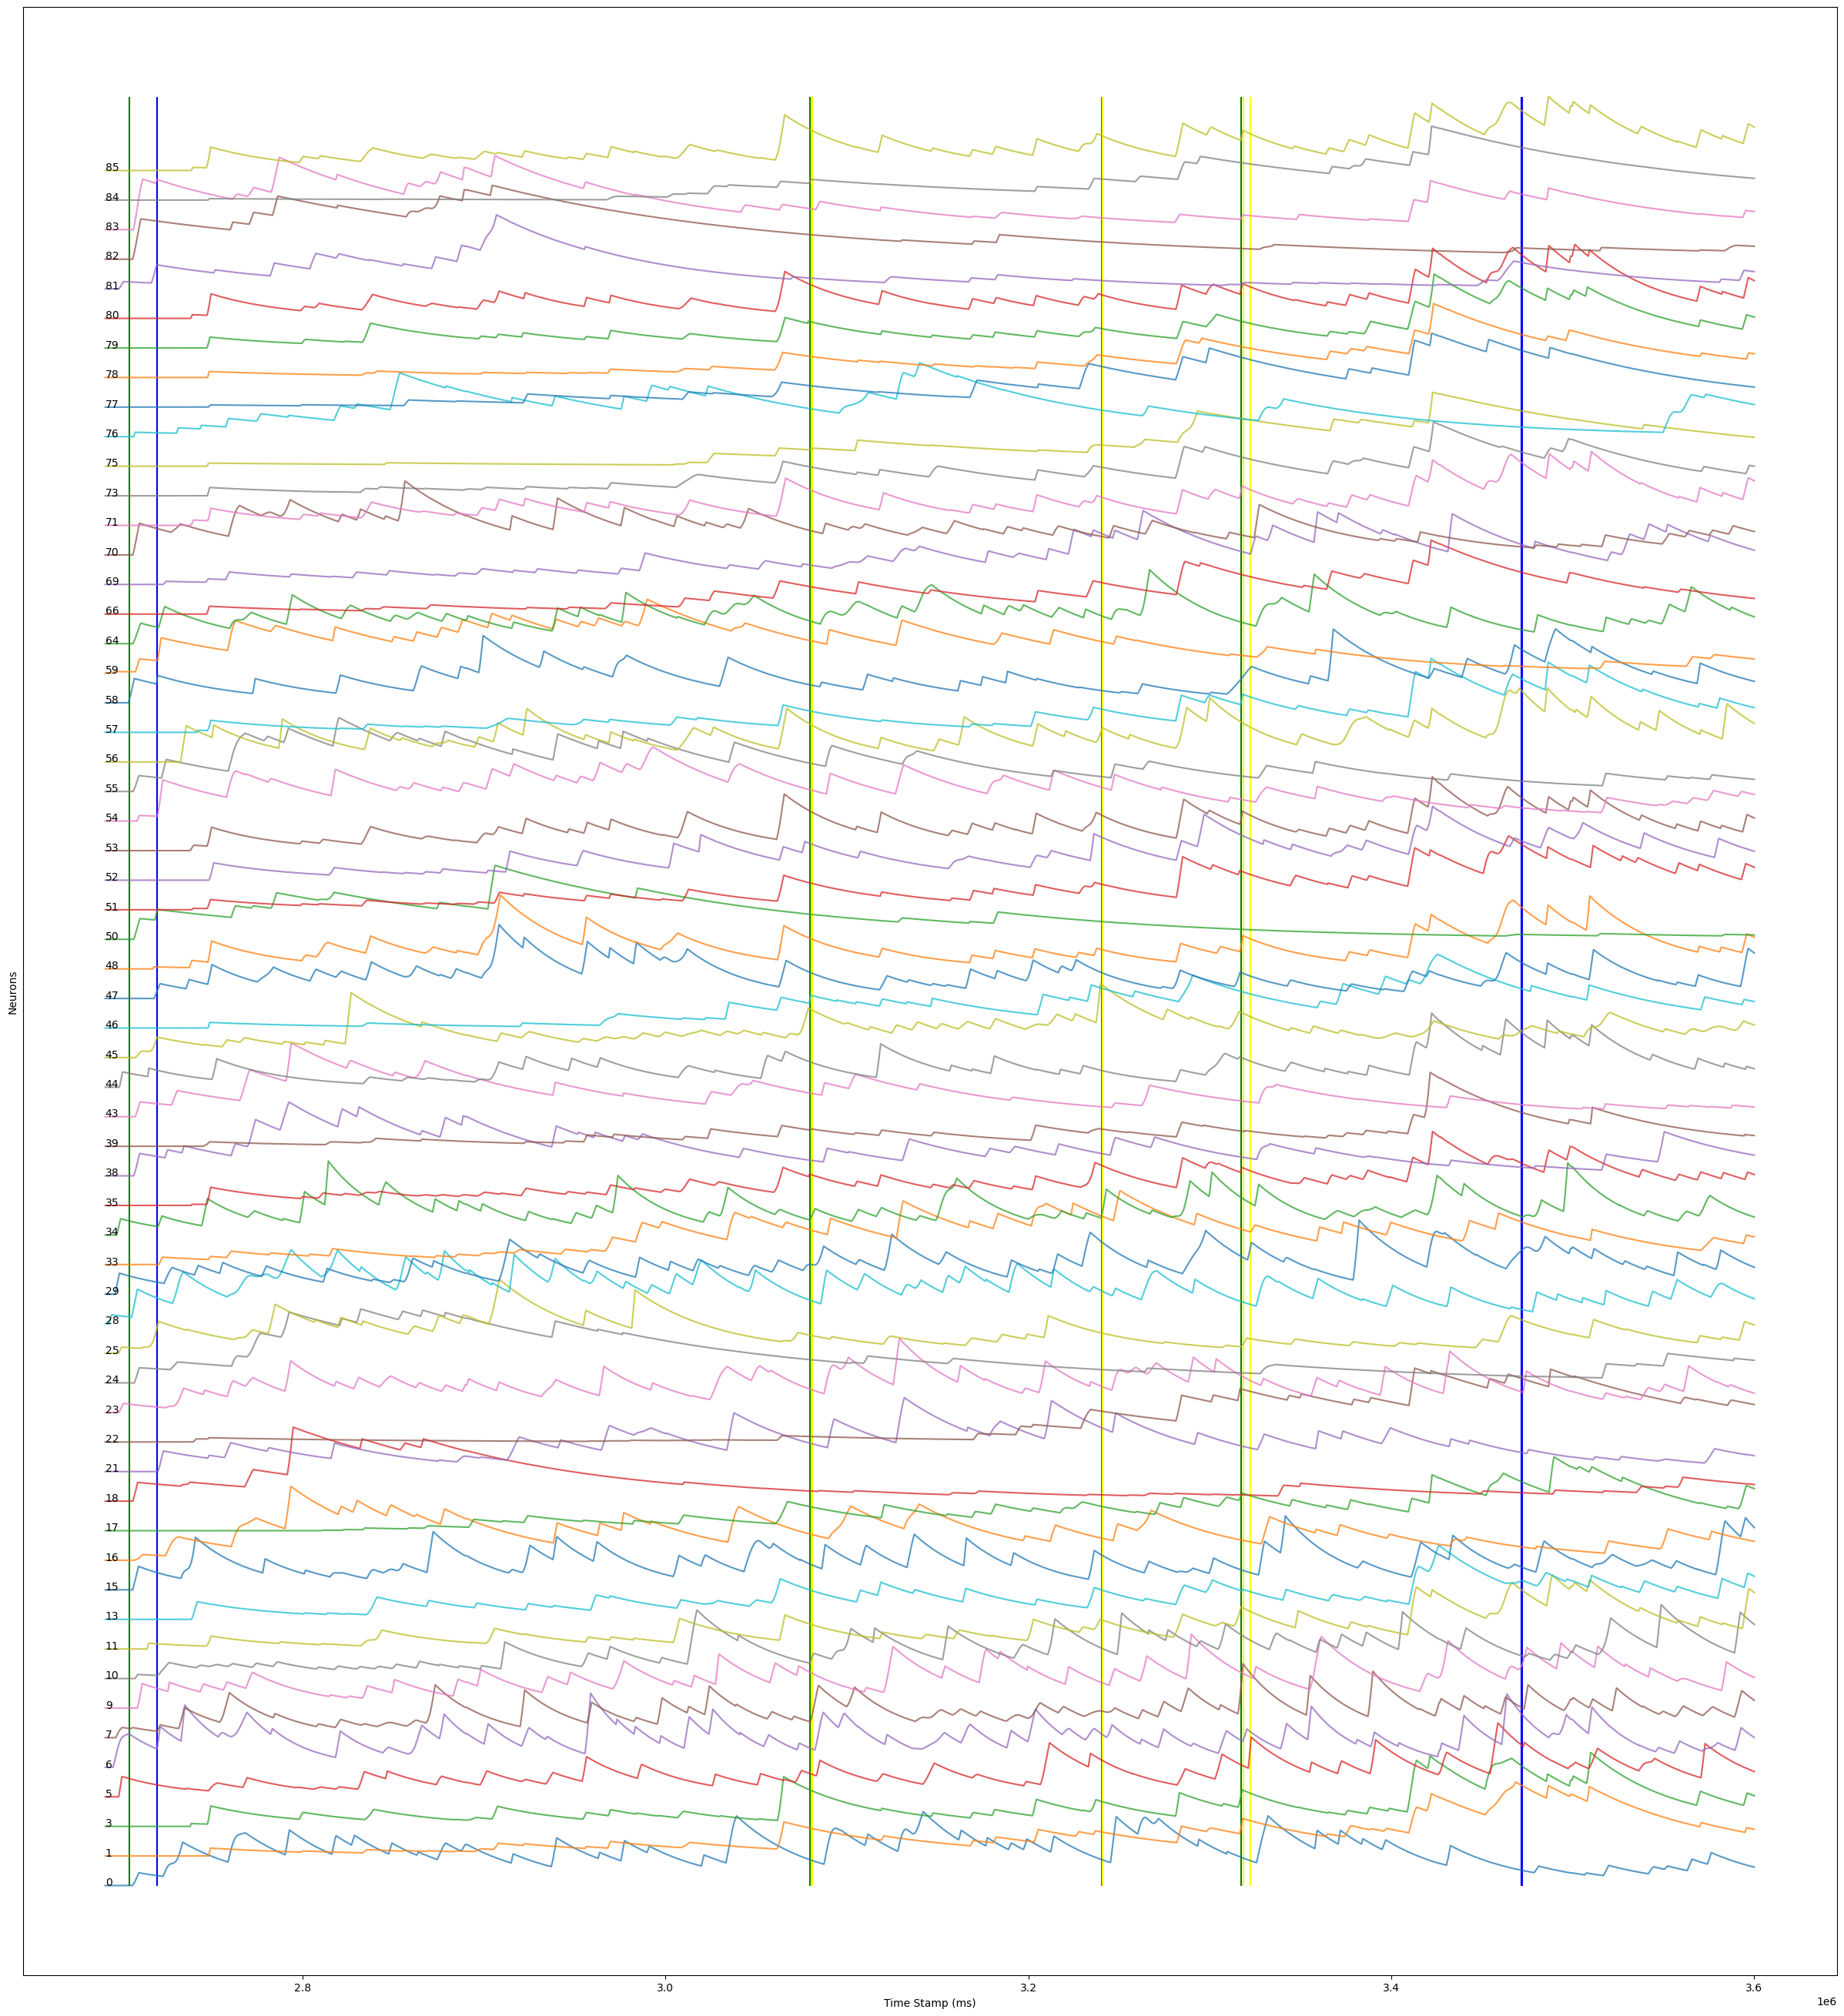

In [534]:
plot_multiple_traces(data,neuron_ids,behavior_data)

# Setting up

In [535]:
binSize = 30000  #how many ms each bin
binName = '30sec'
if session == 'S1':
    startBin = 0
    endBin = 29
elif session == 'S4':
    startBin = 90
    endBin = 119

## zscore functions

In [536]:
# Contains left and right ends
def calculate_window(analyzed_zscore_df, action , time_window):
    start = time_window[0]
    end = time_window[1]
    output_df = analyzed_zscore_df
    for i in range(start,end + 1):
        # only line 2 so the mean is the same to line 2.
        series_positive = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) > 0].mean()
        series_positive.name = action+"_positive_W"+str(i)
        series_negative = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) == 0].mean()
        series_negative.name = action+"_negative_W"+str(i)
        output_df = output_df.append(series_positive)
        output_df = output_df.append(series_negative)
    return output_df

In [537]:
def calculate_zscore (session, input_df):
    neuron_ids = input_df.columns.values.tolist()
    neuron_ids = list(filter(lambda x:type(x) == int,neuron_ids))
#     if session == "S1":
#         analyzed_df = input_df.loc[0:14,:]
#     elif session == "S4":
#         analyzed_df = input_df.loc[45:59,:]
    analyzed_df = input_df.loc[startBin:endBin,:]
    neuron_value = analyzed_df.loc[:,neuron_ids]
    behavior_value = analyzed_df.loc[:,event_list]
    zscore_df = zscore(neuron_value,axis = 0)
    sum_zscore_df = pd.merge(zscore_df,behavior_value,left_index=True,right_index=True)
#     print(sum_zscore_df)
    output_zscore_df = sum_zscore_df
    for event in event_dict:
        output_zscore_df = calculate_window(output_zscore_df, event, event_dict[event])
    return output_zscore_df

In [538]:
def calculate_mean(Series,ngtv_near=0.1,ngtv_far=0,pstv_near=0.1,pstv_far=0):
    series=Series.sort_values()
    # total number
    total = len(Series)
    print('total',total)
    print(Series.to_list())
    
    # ngtv number
    ngtv_series= series[series<0]
    ngtv_number = len(ngtv_series)
    
    # pstv number
    pstv_series = series[series>0]
    pstv_number = len(pstv_series)
    
    # number of ngtv be analyzed
    ngtv_series_analyzed = ngtv_series[round(len(ngtv_series)*ngtv_far):round(len(ngtv_series)*(1-ngtv_near))]
    ngtv_analyzed_number = len(ngtv_series_analyzed)
    
    # analyzed ngtv neuron ID
    ngtv_neurons_list = ngtv_series_analyzed.index.to_list()
    ngtv_neurons=','.join([str(i) for i in ngtv_neurons_list])
#     print(ngtv_neurons)
    
    # analyzed ngtv neuron zscore
    ngtv_neurons_zscore_list = ngtv_series_analyzed.values.tolist()
    ngtv_neurons_zscore = ','.join([str(i) for i in ngtv_neurons_zscore_list])
#     print(ngtv_neurons_zscore)
#     print(type(ngtv_neurons_zscore))
    
    # ngtv mean
    ngtv_mean = ngtv_series_analyzed.mean()
    
    # number of pstv be analyzed
    pstv_series_analyzed = pstv_series[round(len(pstv_series)*pstv_near):round(len(pstv_series)*(1-pstv_far))]
    pstv_analyzed_number = len(pstv_series_analyzed)
    
    # analyzed pstv neuron ID
    pstv_neurons_list = pstv_series_analyzed.index.to_list()
    pstv_neurons=','.join([str(i) for i in pstv_neurons_list])
#     print(pstv_neurons)
    
    # analyzed pstv neuron zscore
    pstv_neurons_zscore_list = pstv_series_analyzed.values.tolist()
    pstv_neurons_zscore = ','.join([str(i) for i in pstv_neurons_zscore_list])
#     print(pstv_neurons_zscore)
#     print(type(pstv_neurons_zscore))
    
    # pstv mean
    pstv_mean = pstv_series_analyzed.mean()
    
    out = pd.Series([total,ngtv_number,ngtv_near,ngtv_far,ngtv_analyzed_number,ngtv_neurons,ngtv_neurons_zscore,ngtv_mean,pstv_number,pstv_near,pstv_far,pstv_analyzed_number,pstv_neurons,pstv_neurons_zscore,pstv_mean],index=["total neuron","ngtv neuron","near (%) in the ngtv side", "far (%) in the ngtv side","ngtv neuron to be analyzed","analyzed ngtv neuron ID","analyzed ngtv zscore","negative mean","pstv neuron","near (%) in the pstv side","far (%) in the pstv side","pstv neuron to be analyzed","analyzed pstv neuron ID","analyzed pstv zscore","positive mean"])
#     out = pd.concat([Series,out])
    return out

# Calculate AUC
## Merge behavior and timestamp


In [539]:
S_df = data['S'].to_pandas()  
S_df = S_df.transpose()

In [540]:
S_df.reset_index(drop=True, inplace = True)
total_pd = pd.merge(S_df, behavior_data,left_index = True,right_index = True,how = 'left')
total_pd

,0,1,3,5,6,7,9,10,11,13,...,83,84,85,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP,ALP_Timeout
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80076,2691173,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80077,2691206,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80078,2691239,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80079,2691274,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80080,2691307,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80081,2691341,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80082,2691374,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80083,2691407,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80084,2691441,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80085,2691475,0,0,0,0,0


## AUC of S per Binsize

In [541]:
total_pd[binName]=total_pd['Time Stamp (ms)'].map(lambda x: math.floor(x/binSize))
pd.set_option('display.min_rows',50)
total_pd

,0,1,3,5,6,7,9,10,11,13,...,84,85,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP,ALP_Timeout,30sec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80076,2691173,0,0,0,0,0,89
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80077,2691206,0,0,0,0,0,89
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80078,2691239,0,0,0,0,0,89
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80079,2691274,0,0,0,0,0,89
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80080,2691307,0,0,0,0,0,89
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80081,2691341,0,0,0,0,0,89
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80082,2691374,0,0,0,0,0,89
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80083,2691407,0,0,0,0,0,89
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80084,2691441,0,0,0,0,0,89
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80085,2691475,0,0,0,0,0,89


### Edit time manually

In [542]:
# total_pd[binName] = total_pd[binName]+71
total_pd

,0,1,3,5,6,7,9,10,11,13,...,84,85,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP,ALP_Timeout,30sec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80076,2691173,0,0,0,0,0,89
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80077,2691206,0,0,0,0,0,89
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80078,2691239,0,0,0,0,0,89
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80079,2691274,0,0,0,0,0,89
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80080,2691307,0,0,0,0,0,89
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80081,2691341,0,0,0,0,0,89
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80082,2691374,0,0,0,0,0,89
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80083,2691407,0,0,0,0,0,89
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80084,2691441,0,0,0,0,0,89
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80085,2691475,0,0,0,0,0,89


In [543]:
AUC_pd = total_pd.groupby(binName).sum()
columns = neuron_ids.tolist()
columns = columns + event_list
AUC_pd = AUC_pd[columns]
AUC_pd

,0,1,3,5,6,7,9,10,11,13,...,80,81,82,83,84,85,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,,,,,,,,,,,,,,,,,,
89,0.005029,0.000000,0.000000,1.581434,3.448053,1.235238,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.310299,0.000000,0.000000,0.000000,0.000000,0,0,0,0
90,2.096764,0.000000,0.000000,0.483433,3.860246,1.229600,2.887675,1.318409,0.487525,0.000000,...,0.000000,1.946821,3.579936,3.408558,0.000000,0.000000,1,1,1,0
91,2.136197,0.327316,1.012754,1.004134,5.386439,7.179044,1.502011,0.614840,0.873879,1.599672,...,2.445063,0.270332,0.000000,0.000000,0.049008,2.524611,0,0,0,0
92,2.049237,0.000000,0.000000,1.049980,5.008380,0.623538,1.545548,0.891403,0.136360,0.000000,...,0.000000,1.176571,3.547701,3.285144,0.000000,0.000000,0,0,0,0
93,3.236817,0.049260,0.352721,0.616863,2.229205,1.206286,0.154185,0.440712,0.092625,0.211145,...,0.936538,1.854031,0.233387,0.345309,0.000000,1.044266,0,0,0,0
94,1.615626,0.142244,0.540802,2.741615,1.803979,1.663312,1.913707,0.514374,1.505666,1.731091,...,1.651883,0.111628,0.000000,0.000000,0.007024,1.655024,0,0,0,0
95,1.636315,0.057056,0.000000,0.965114,7.093429,6.500039,0.534097,0.867970,0.000000,0.556995,...,0.381840,1.239711,2.324777,2.016448,0.000000,0.574465,0,0,0,0
96,0.593101,0.435656,0.832943,1.583657,2.557236,0.000000,3.000544,1.075322,1.392582,0.440158,...,2.230206,5.117113,1.924822,2.169348,0.000000,1.359495,0,0,0,0
97,2.748358,0.074119,0.000000,1.648757,3.048614,4.865046,1.476091,1.295886,0.061298,0.751261,...,0.574316,0.000000,0.000000,0.000000,0.000000,0.693480,0,0,0,0


### Save data

In [544]:
AUC_pd.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_AUC_Ori.csv"))

### Zscore

In [545]:
AUC_zscore = calculate_zscore(session, AUC_pd)

#### Save Zscore

In [546]:
AUC_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_AUC_zscore.csv"))

### Summary

In [547]:
zscore_summary_index_list = list(filter(lambda x: type(x) != int,AUC_zscore.index.tolist()))
AUC_zscore_summary = AUC_zscore.loc[zscore_summary_index_list,:]
AUC_zscore_summary

,0,1,3,5,6,7,9,10,11,13,...,80,81,82,83,84,85,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,,,,,,,,,,,,,,,,,,
ALP_positive_W-6,0.270908,0.266204,0.458828,0.228007,-0.074414,-0.485709,0.439692,-0.993918,-0.016036,-0.414113,...,0.326632,1.306300,0.203881,0.396343,-0.158683,0.197944,1.000000,0.000000,0.333333,0.666667
ALP_negative_W-6,0.189518,-0.214870,-0.230138,-0.208637,-0.035730,-0.017570,-0.157554,0.037736,-0.236132,-0.129238,...,-0.289946,-0.189962,0.047557,-0.008370,0.015584,-0.236079,0.285714,0.047619,0.142857,0.142857
ALP_positive_W-5,0.290457,-0.525331,-0.720867,-0.715778,-0.441169,-0.068527,-0.138085,0.688388,-0.638034,0.146466,...,-0.414298,-0.464191,-0.397874,-0.606123,-0.580816,-0.482577,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-5,0.163555,-0.071469,-0.060592,-0.053991,0.058548,-0.052971,-0.020604,-0.195255,-0.163128,-0.128293,...,-0.134028,0.050276,0.105034,0.157187,0.212746,-0.125281,0.409091,0.045455,0.181818,0.227273
ALP_positive_W-4,0.115790,-0.038499,-0.073463,0.514340,0.844665,-0.298650,-0.078348,-0.584656,-0.274210,-0.446284,...,-0.358407,-0.181183,-0.212691,-0.418037,-0.302153,-0.134959,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-4,0.119064,0.001426,-0.050180,-0.090841,-0.065559,0.033062,0.024715,-0.074146,-0.114404,-0.063171,...,-0.034776,0.073927,0.074861,0.121346,0.141601,-0.080483,0.391304,0.130435,0.173913,0.217391
ALP_positive_W-3,-0.248828,-0.431063,-0.460702,-0.236093,-0.374432,-0.241296,0.510291,0.141188,-0.378724,-0.243880,...,-0.498965,-0.412504,-0.397874,-0.594472,-0.064429,-0.471733,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-3,0.108006,0.125599,0.095952,-0.012260,0.138417,0.008971,-0.043434,-0.166500,0.011751,-0.028678,...,0.090330,0.076251,0.074340,0.141674,0.081503,0.061338,0.375000,0.125000,0.166667,0.208333
ALP_positive_W-2,0.584851,-0.130059,-0.257912,-0.371116,0.671120,0.066445,0.654295,1.034084,-0.030332,-0.601138,...,-0.452647,-0.434757,-0.255125,-0.571978,0.374702,-0.226099,0.666667,0.000000,0.333333,0.333333


In [548]:
AUC_zscore_calculate_version1 = AUC_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
AUC_zscore_summary_version1 = pd.concat([AUC_zscore_summary,AUC_zscore_calculate_version1],axis=1)
AUC_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+day + session+"_AUC_10pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[0.2709080470910763, 0.2662044150286488, 0.4588284622479284, 0.22800676063726863, -0.07441356546071805, -0.4857087020452477, 0.4396916029049205, -0.9939177526772403, -0.016035572834183776, -0.41411281276502465, -0.38304800428829733, -0.4258576062478236, 0.11188155376478011, -0.5603324266392459, 0.4925678946923083, -0.5642091190029727, 0.519495271290082, -0.6777728996617016, 0.8838471921467651, -0.46572510905396675, 0.39036797003783663, 0.5690905853862428, -0.5335189108894007, -0.10734240275777322, 0.14831474826031568, -0.15593756984656187, -0.33151036422210484, -0.39943701043247754, 0.3395524533180028, 0.063764684992078, 1.1376711812405542, 0.9626510861394836, 1.0293709952751253, 0.049442979935290864, -0.3805584439428376, 0.216745584600654, 0.879552514277781, -0.14481084257917234, 0.18131650922898657, -0.08668300877306086, 0.16132669896841112, 1.045100186267731, 0.04496761628659588, -0.1615347348224633, -0.19102488533002493, -0.6858670259674594, 0.31521343087251313, 0.35505254

total 59
[-0.014061484376304056, 0.033260904052365516, 0.04594730717642058, -0.020129476471022742, -0.04737308809959247, -0.022049916241168054, 0.1540401400260619, 0.11815649126720741, 0.09372971969666236, 0.10660892331846553, 0.049848908719539384, -0.06573869757921227, 0.06787591075423564, -0.18588209213512386, 0.06114363095672063, 0.11014724131948987, -0.016670758927232004, -0.1881629101741793, -0.07513243104103164, -0.04129464001711776, -0.008676376970560982, 0.003519184659162547, -0.034657641077377045, 0.04295640469535103, -0.14734534462716237, -0.01642825496372276, -0.16800368364997634, 0.050906356469486505, 0.11949206451946745, 0.04592337495955236, 0.04119584974414229, 0.03753377791774991, -0.13690757132760517, 0.09934475944324977, 0.0938580081068617, 0.05731941925689273, -0.031170107077188466, -0.16287503471536666, 0.025262988523334792, 0.06552557600626277, -0.11001173518526906, -0.0846745675668402, 0.03599353502255958, 0.015998615402139666, 0.10853984532170967, -0.0655553586286

In [549]:
AUC_zscore_calculate_version2 = AUC_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
AUC_zscore_summary_version2 =pd.concat([AUC_zscore_summary, AUC_zscore_calculate_version2],axis=1)
AUC_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+day+ session + "_AUC_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[0.2709080470910763, 0.2662044150286488, 0.4588284622479284, 0.22800676063726863, -0.07441356546071805, -0.4857087020452477, 0.4396916029049205, -0.9939177526772403, -0.016035572834183776, -0.41411281276502465, -0.38304800428829733, -0.4258576062478236, 0.11188155376478011, -0.5603324266392459, 0.4925678946923083, -0.5642091190029727, 0.519495271290082, -0.6777728996617016, 0.8838471921467651, -0.46572510905396675, 0.39036797003783663, 0.5690905853862428, -0.5335189108894007, -0.10734240275777322, 0.14831474826031568, -0.15593756984656187, -0.33151036422210484, -0.39943701043247754, 0.3395524533180028, 0.063764684992078, 1.1376711812405542, 0.9626510861394836, 1.0293709952751253, 0.049442979935290864, -0.3805584439428376, 0.216745584600654, 0.879552514277781, -0.14481084257917234, 0.18131650922898657, -0.08668300877306086, 0.16132669896841112, 1.045100186267731, 0.04496761628659588, -0.1615347348224633, -0.19102488533002493, -0.6858670259674594, 0.31521343087251313, 0.35505254

total 59
[0.02716749310733034, 0.05422038352242268, 0.03980085141949943, -0.00928197149963187, 0.015646355618599356, -0.023538002873591053, 0.10205989728268433, 0.061556259162121645, 0.032927892127013164, 0.04627760923874359, -0.03313847359757682, -0.04952643053058717, 0.02797539852190849, -0.09151665883801341, 0.08522645152728923, 0.12389580914399563, 0.061332273885323564, -0.1459231901345499, -0.0645137535691937, -0.029227571974743637, 0.005607966984383626, 0.10817645171438318, 0.006938846949416876, 0.060629374466682935, -0.0980420132969547, 0.09631039767724858, -0.09669119074040054, 0.01797838183869802, 0.04794864048881161, 0.11706619713270308, -0.03408751484676897, -0.01475845464282445, -0.0670299820020985, 0.043161337036477794, 0.06223424989868036, 0.04061734569883994, -0.04617742386018065, -0.10659456025519004, -0.018785272203333873, 0.06653559058294287, -0.050543403471241234, -0.07480060062810387, 0.029529724423886794, 0.09035414372743238, 0.10768567478451907, -0.092031706564163

# Calculate SperEvt

In [550]:
mark = np.zeros(len(neuron_ids))
flag = np.zeros(len(neuron_ids))

SperEvt_pd = total_pd.copy(deep=True)
for neuron_id in neuron_ids:
    SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values==neuron_id)[0][0]) + 1,str(neuron_id)+'_mark',0)
for index,row in SperEvt_pd.iterrows():
    for i,neuron_id in enumerate(neuron_ids):
        if row[neuron_id] == 0 and flag[i] != 0:
            flag[i]=0
        elif row[neuron_id] == 0 and flag[i] == 0:
            continue
        elif row[neuron_id] != 0 and flag[i] != 0:   
            SperEvt_pd.loc[index,str(neuron_id)+'_mark'] = mark[i]
        else:
            flag[i]=1
            mark[i]=mark[i]+1
            SperEvt_pd.loc[index,str(neuron_id)+'_mark'] = mark[i]


In [551]:
for i in range(len(neuron_ids)-1,-1,-1):
    SUM = pd.DataFrame()
    SUM[str(neuron_ids[i])+'_sum'] = SperEvt_pd[neuron_ids[i]].groupby(SperEvt_pd[str(neuron_ids[i])+'_mark']).sum()
    temp = pd.merge(SperEvt_pd[str(neuron_ids[i])+'_mark'],SUM,how='left',left_on=str(neuron_ids[i])+'_mark',right_index=True)
#     print(temp)
#     print(type(new_pd[column_name[i]].groupby(new_pd[str(column_name[i])+'_mark']).sum()))
    SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values==str(neuron_ids[i])+'_mark')[0][0])+1,str(neuron_ids[i])+'_sum',0)
    SperEvt_pd.update(temp)

SperEvt_pd.insert(int(np.argwhere(SperEvt_pd.columns.values == 'Time Stamp (ms)')[0][0])+1,'Time Interval (ms)',SperEvt_pd['Time Stamp (ms)'].diff())
SperEvt_pd.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_SperEvt.csv"))

# Calculate Frq

In [552]:
behavior_df = AUC_pd.loc[:, event_list]
behavior_df 

,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,
89,0,0,0,0
90,1,1,1,0
91,0,0,0,0
92,0,0,0,0
93,0,0,0,0
94,0,0,0,0
95,0,0,0,0
96,0,0,0,0
97,0,0,0,0


In [553]:
neuron_marks = [str(i)+'_mark' for i in neuron_ids]
total_neurons_df = SperEvt_pd.loc[:,neuron_ids.tolist() + neuron_marks]
diff_df = total_neurons_df.diff()
diff_df = diff_df[neuron_marks]
diff_df[diff_df < 0] = 0
frequency_df = diff_df[diff_df>0]
# frequency_df

In [554]:
frequency_df[binName]=total_pd[binName]
frequency_df = frequency_df.groupby(binName).count()
frequency_df.columns = frequency_df.columns.str.rstrip('_mark').astype('int64')
frequency_df = pd.merge(frequency_df,behavior_df,left_index = True, right_index = True)
frequency_df.to_csv(os.path.join(output_path, mouseID+'_'+day + session + "_Frq_Ori.csv"))
frequency_df

,0,1,3,5,6,7,9,10,11,13,...,80,81,82,83,84,85,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,,,,,,,,,,,,,,,,,,
89,1,0,0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
90,2,0,0,0,1,2,2,2,1,0,...,0,1,1,2,0,0,1,1,1,0
91,1,1,2,2,2,2,2,3,1,1,...,2,1,0,0,1,2,0,0,0,0
92,0,0,0,1,1,1,1,2,1,0,...,0,2,3,3,0,0,0,0,0,0
93,2,1,1,3,1,2,1,3,1,2,...,2,2,1,1,0,2,0,0,0,0
94,2,1,1,2,1,2,3,3,1,2,...,1,1,0,0,1,2,0,0,0,0
95,2,2,0,1,2,2,0,2,0,1,...,1,2,1,3,0,1,0,0,0,0
96,1,3,3,2,1,0,2,3,2,1,...,3,2,2,2,0,3,0,0,0,0
97,2,1,0,2,2,1,1,0,1,2,...,1,0,0,0,0,1,0,0,0,0


## Zscore

In [555]:
Frq_zscore = calculate_zscore(session, frequency_df)

### Save Zscore

In [556]:
Frq_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_Frq_zscore.csv"))

## Summary

In [557]:
Frq_zscore_summary = Frq_zscore.loc[zscore_summary_index_list,:]
Frq_zscore_summary

,0,1,3,5,6,7,9,10,11,13,...,80,81,82,83,84,85,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,,,,,,,,,,,,,,,,,,
ALP_positive_W-6,-0.199007,0.160956,0.377519,0.796521,-0.063372,-1.093216,-0.093659,-0.317221,0.149813,-0.930809,...,0.448461,4.303315e-01,0.649934,0.358854,7.401487e-17,1.968748e-01,1.000000,0.000000,0.333333,0.666667
ALP_negative_W-6,0.085289,0.022994,0.034320,-0.101811,0.027160,-0.052058,-0.026760,0.135952,-0.206884,0.018996,...,-0.085421,-6.147593e-02,-0.145903,0.017088,1.721184e-01,-8.437492e-02,0.285714,0.047619,0.142857,0.142857
ALP_positive_W-5,0.298511,-0.160956,-0.652078,-0.041922,-0.063372,-0.572637,0.374634,-0.713746,0.149813,0.398918,...,-0.298974,-8.606630e-01,-0.278543,-0.438599,-4.016097e-01,-1.968748e-01,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-5,-0.018092,0.014632,0.112320,-0.003811,0.051850,-0.099383,-0.114945,0.151401,-0.213370,-0.185356,...,0.006795,1.760447e-01,-0.046424,0.068871,2.373148e-01,-5.369313e-02,0.409091,0.045455,0.181818,0.227273
ALP_positive_W-4,0.298511,0.160956,0.377519,-0.041922,-0.063372,-0.572637,-0.093659,-0.713746,0.149813,-0.044324,...,0.448461,0.000000e+00,0.185695,-0.438599,3.700743e-17,5.906244e-01,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-4,-0.047589,-0.034990,-0.040289,0.030986,-0.008266,-0.006790,-0.012216,0.113786,-0.219291,-0.082867,...,-0.103991,5.613019e-02,-0.076700,0.064143,1.396903e-01,-1.797553e-01,0.391304,0.130435,0.173913,0.217391
ALP_positive_W-3,0.298511,-0.160956,0.377519,-0.461144,0.570352,0.989100,-0.093659,-0.713746,0.649189,-0.930809,...,-0.298974,-4.303315e-01,-0.278543,-0.039873,-4.016097e-01,-1.968748e-01,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-3,-0.074628,0.080478,0.034320,0.167689,-0.063372,-0.182203,-0.035122,0.128871,-0.162297,0.066486,...,0.074744,1.075829e-01,-0.046424,0.009968,1.506036e-01,9.251859e-18,0.375000,0.125000,0.166667,0.208333
ALP_positive_W-2,0.796030,0.160956,0.034320,-0.041922,0.570352,-0.052058,1.311220,-0.317221,-0.848939,-0.044324,...,0.074744,-8.606630e-01,-0.278543,-0.837325,1.204829e+00,-1.968748e-01,0.666667,0.000000,0.333333,0.333333


In [558]:
Frq_zscore_calculate_version1 = Frq_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Frq_zscore_summary_version1 = pd.concat([Frq_zscore_summary, Frq_zscore_calculate_version1],axis=1)
Frq_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+ day + session +"_Frq_10pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.1990074380419976, 0.16095569499491255, 0.37751902268001913, 0.7965214354856052, -0.06337242505244767, -1.0932163332202425, -0.09365858115816923, -0.31722063428725783, 0.14981285083167659, -0.9308086350736661, -0.5191220960013095, -0.5191220960013098, -0.312347523777212, -0.8250286473253902, 0.39070190053016324, -0.7578757672667774, -0.2985111570629969, -0.8337493486335759, 0.12446097204675327, 0.1005037815259211, -0.703989469396047, 0.9542007856917757, 0.7052788415982688, 0.03809696588797299, -0.15369465587356812, -0.07474350927519358, -0.29851115706299686, -0.3535533905932737, 0.3646984043128986, 0.44846105565116146, 0.30667556803682644, -0.086386842558136, 0.23186944788008412, 0.37729962733528666, -0.08192319205190397, -0.07001400420140036, 1.1102230246251565e-16, -0.3666793988112845, 0.13972392984978663, -0.21417646843905977, 0.39223227027636803, 0.3666793988112846, 7.401486830834377e-17, -0.7595039877349095, 0.3521803625302497, -0.9166666666666666, 7.401486830834377e-1

In [559]:
Frq_zscore_calculate_version2 = Frq_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Frq_zscore_summary_version2 = pd.concat([Frq_zscore_summary,Frq_zscore_calculate_version2],axis=1)
Frq_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+ day + session+"_Frq_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[-0.1990074380419976, 0.16095569499491255, 0.37751902268001913, 0.7965214354856052, -0.06337242505244767, -1.0932163332202425, -0.09365858115816923, -0.31722063428725783, 0.14981285083167659, -0.9308086350736661, -0.5191220960013095, -0.5191220960013098, -0.312347523777212, -0.8250286473253902, 0.39070190053016324, -0.7578757672667774, -0.2985111570629969, -0.8337493486335759, 0.12446097204675327, 0.1005037815259211, -0.703989469396047, 0.9542007856917757, 0.7052788415982688, 0.03809696588797299, -0.15369465587356812, -0.07474350927519358, -0.29851115706299686, -0.3535533905932737, 0.3646984043128986, 0.44846105565116146, 0.30667556803682644, -0.086386842558136, 0.23186944788008412, 0.37729962733528666, -0.08192319205190397, -0.07001400420140036, 1.1102230246251565e-16, -0.3666793988112845, 0.13972392984978663, -0.21417646843905977, 0.39223227027636803, 0.3666793988112846, 7.401486830834377e-17, -0.7595039877349095, 0.3521803625302497, -0.9166666666666666, 7.401486830834377e-1

# Calculate Amp

In [560]:
Amp_df = AUC_pd.loc[startBin:endBin,neuron_ids]/frequency_df.loc[startBin:endBin,neuron_ids]
Amp_df = Amp_df.fillna(0)
Amp_df = Amp_df.replace(np.inf,0)
Amp_df = pd.merge(Amp_df,AUC_pd.loc[startBin:endBin,event_list],left_index=True,right_index=True)
Amp_df.to_csv(os.path.join(output_path, mouseID+'_'+day + session+"_Amp_Ori.csv"))

## Zscore

In [561]:
Amp_zscore = calculate_zscore(session, Amp_df)

### Save Zscore

In [562]:
Amp_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+session+"_Amp_zscore.csv"))

## Summary

In [563]:
Amp_zscore_summary = Amp_zscore.loc[zscore_summary_index_list,:]
Amp_zscore_summary

,0,1,3,5,6,7,9,10,11,13,...,80,81,82,83,84,85,ALP,IALP,RNFS,ALP_Timeout
30sec,,,,,,,,,,,,,,,,,,,,,
ALP_positive_W-6,0.357008,0.463702,0.743986,0.019900,-0.140520,-0.365996,0.560333,-0.801267,0.055967,-0.809057,...,0.370825,1.076521,-0.001210,0.383815,-0.266366,0.491343,1.000000,0.000000,0.333333,0.666667
ALP_negative_W-6,0.121727,-0.190166,-0.264013,-0.197280,-0.014395,0.103139,-0.180172,-0.020100,-0.137317,-0.076940,...,-0.265485,-0.186241,0.053175,0.015162,-0.028819,-0.240667,0.285714,0.047619,0.142857,0.142857
ALP_positive_W-5,0.341830,-0.246205,-0.541688,-0.621076,-0.204426,0.585651,-0.315884,0.209652,-0.630126,0.172794,...,-0.117402,-0.449621,-0.350146,-0.640009,-0.527527,-0.361764,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-5,0.134185,-0.113495,-0.111347,-0.050353,0.005486,-0.029116,0.026594,-0.138123,-0.052318,-0.067511,...,-0.119619,0.014813,0.076915,0.113920,0.193765,-0.082740,0.409091,0.045455,0.181818,0.227273
ALP_positive_W-4,-0.177767,-0.151440,-0.162970,0.791080,0.944745,0.087037,0.275858,-0.463287,-0.156685,-0.353286,...,-0.483535,0.004728,-0.114687,-0.210114,-0.177100,-0.371801,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-4,0.142901,0.061222,-0.011192,-0.165132,-0.045195,0.032557,-0.043063,-0.080446,0.010494,-0.019910,...,0.070544,0.068501,0.047784,0.075075,0.116326,0.047024,0.391304,0.130435,0.173913,0.217391
ALP_positive_W-3,-0.283025,-0.285155,-0.398360,0.294241,-0.251404,-0.606633,0.451407,0.607506,-0.543896,0.359401,...,-0.428481,-0.366641,-0.350146,-0.613378,0.042622,-0.132229,0.000000,0.000000,0.000000,0.000000
ALP_negative_W-3,0.107977,0.094338,0.047043,-0.133380,0.122073,0.095276,-0.034640,-0.227725,0.080542,-0.075664,...,0.082739,0.086640,0.055586,0.161023,0.061678,0.034215,0.375000,0.125000,0.166667,0.208333
ALP_positive_W-2,-0.128880,-0.195544,-0.336818,-0.419405,0.061038,0.059217,-0.296928,1.026154,0.248654,-0.503867,...,-0.543161,-0.402367,-0.168641,-0.561967,0.240421,-0.386310,0.666667,0.000000,0.333333,0.333333


In [564]:
Amp_zscore_calculate_version1 = Amp_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Amp_zscore_summary_version1 = pd.concat([Amp_zscore_summary, Amp_zscore_calculate_version1],axis=1)
Amp_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID + '_' + day + session+"_Amp_10pct_"+str(int(binSize/1000))+"sec.csv"))

total 59
[0.35700767447393494, 0.4637017494033558, 0.7439857164648455, 0.019899964675183363, -0.14051968259118583, -0.3659959838350502, 0.5603332148206176, -0.8012665387734991, 0.055967446265889786, -0.8090572892964261, -0.21105061664254854, -0.11255609470194165, 0.21757273155128223, -0.47253809345292935, 0.7006747525917003, -0.4058796480830565, 0.8919487750981046, -0.7079761205913854, 0.6837995073606719, -0.13615340810291474, 0.6992341406176132, 0.6624144365704614, -0.5008398215459734, 0.2594371349716578, 0.5983483918967805, 0.031596511581423146, -0.19293155907638707, -0.3926605601379822, 0.1343573454604078, -0.17076210723567567, 1.097343311638481, 0.7750797320566877, 1.4142191763171847, 0.03522741630568208, -0.4946451382013202, 0.36826512336073963, 1.1130723470904502, 0.14685732290366596, 0.2732719077939341, 0.23649521786873598, -0.07264414075728269, 1.2130689137024107, 0.001698151687407834, -0.6038130385687956, -0.3232390009327352, -0.29986710510927433, 0.36496285573857773, 0.650523

In [565]:
Amp_zscore_calculate_version2 = Amp_zscore_summary.loc[:,neuron_ids].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Amp_zscore_summary_version2 = pd.concat([Amp_zscore_summary,Amp_zscore_calculate_version2],axis=1)
Amp_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_' + day + session + "_Amp_20pct_" + str(int(binSize/1000)) + "sec.csv"))

total 59
[0.35700767447393494, 0.4637017494033558, 0.7439857164648455, 0.019899964675183363, -0.14051968259118583, -0.3659959838350502, 0.5603332148206176, -0.8012665387734991, 0.055967446265889786, -0.8090572892964261, -0.21105061664254854, -0.11255609470194165, 0.21757273155128223, -0.47253809345292935, 0.7006747525917003, -0.4058796480830565, 0.8919487750981046, -0.7079761205913854, 0.6837995073606719, -0.13615340810291474, 0.6992341406176132, 0.6624144365704614, -0.5008398215459734, 0.2594371349716578, 0.5983483918967805, 0.031596511581423146, -0.19293155907638707, -0.3926605601379822, 0.1343573454604078, -0.17076210723567567, 1.097343311638481, 0.7750797320566877, 1.4142191763171847, 0.03522741630568208, -0.4946451382013202, 0.36826512336073963, 1.1130723470904502, 0.14685732290366596, 0.2732719077939341, 0.23649521786873598, -0.07264414075728269, 1.2130689137024107, 0.001698151687407834, -0.6038130385687956, -0.3232390009327352, -0.29986710510927433, 0.36496285573857773, 0.650523